# Background estimation

In this notebook we'll perform background estimation. We shall make use of the so called **ABCD method**. 
We describe the method briefly in what follows before applying it to our analysis.
Let's assume we identify two variables ($v_1$ and $v_2$) which have uncorrelated distributions for the background.
A cut each of these variables will have an efficiency which is indepedent of whatever selections have been performed on the other variable.
Let's say we divide the 2D-plane ($v_1-v_2$) in four regions (A,B,C,D) being A is the final signal region where both selection requirements on $v_1$ and $v_2$ are applied. Such plane is represented in the following figure.

![Representation of the 2D-plane used to define the ABCD regions for background estimation](img/abcd_method.png "ABCD method")

If the selections are indeed uncorrelated for the background, then one can assume that the ratio of events in each regions can be related as:

\begin{equation}
\frac{N_{A}^{bkg}}{N_{B}^{bkg}} =\frac{N_{C}^{bkg}}{N_{D}^{bkg}} \Leftrightarrow N_{A}^{bkg} =N_{B}^{bkg}\cdot\frac{N_{C}^{bkg}}{N_{D}^{bkg}}
\end{equation}

In the notebook below we shall apply this method to our analysis using two uncorrelated variables: the number of extra PF candidates and the $\Delta\xi$.

## Loading the data and simulations to test the method

The procedure used here is analogous to the one used in the Classification-Training notebook.
After loading the data we run a prepare data method such that we can also run the classifier we have previously trained. In the prepare data method we'll already include the output of the classifier.

**NOTE**: If you are using only part of the data, use corresponding luminosity listed under `Data and MC samples used in the exercise` in the [Twiki](https://twiki.cern.ch/twiki/bin/view/CMS/SWGuideCMSDataAnalysisSchoolCERN2020TaggedProtonsLongExercise#Setting_up_the_analysis):

  Era   | lumi [1/pb]
  ----- | ----
  2017B | 2367.138592
  2017C | 8680.676647
  2017D | 4142.765586
  2017E | 9062.549690
  2017F | 13247.272608
  
  Signal acceptance is obtained from the original ntuples by computing the ratio between the number of events at preselection to the number of events in the original sample. For example, for di-electron sample, execute the following lines in lxplus:
```bash 
root -l /eos/user/c/cmsdas/long-exercises/pps-exclusive-dilepton/ntuples/signal/GGToEE_Elastic_v0_signal_xa120_era2017_preTS2.root
```
In root:
```cpp 
float Nselected = tree->GetEntries()
float Ntotal = evt_count->GetBinContent(1)
cout << "Signal acceptance = " << Nselected / Ntotal << endl;
```  

In [1]:
from snippets.GetData import *
#global configurarables (check the Data-Inspection notebook for consistency)
proton_selection = "MultiRP"
DATAPATH='root://cmseos.fnal.gov//store/user/cmsdas/2022/long_exercises/pps-exclusive-dilepton/h5py'
PATH='output'
#eras=['B','C','D','E','F'] #uncomment to use all data
eras=['B']
lumi=2367.138592
stream='Mu' # 'El' OR 'Mu'

In [2]:
#Execute this lines to copy the files to local folder
# dont forget to run "voms-proxy-init -voms cms -valid 192:00" from terminal
files=[('output-UL2018%s-%s-Rand20.h5'%(era,stream)) for era in eras]
files.append('output-GGToMuMu_Elastic_v0_SignalOnly.h5')
files  = files + ['output-UL2018{}-{}.h5'.format(era,stream) for era in eras]

for f in files:
    print('copying %s'%f)
    !xrdcopy -f {DATAPATH}/{f} {PATH}/.

copying output-UL2018B-Mu-Rand20.h5
[251MB/251MB][100%][==================================================][19.31MB/s]  
copying output-GGToMuMu_Elastic_v0_SignalOnly.h5
[1.538MB/1.538MB][100%][==================================================][525.1kB/s]  
copying output-UL2018B-Mu.h5
[12.57MB/12.57MB][100%][==================================================][4.189MB/s]  


In [3]:
print('[Signal simulation]')
df_signal,df_counts_signal = GetData(PATH+'/output-GGTo{}_Elastic_v0_SignalOnly.h5'.format('EE' if stream=='El' else 'MuMu'), is2018=True)
sig_acc=0.380382 if stream=='El' else 0.33639
sig_xsec=0.046 if stream=='El' else 0.112
print('Selection counts')
print(df_counts_signal)

print('\n')
print('[Data (to be used as background)]')
data_files = [PATH+'/output-UL2018{}-{}-Rand20.h5'.format(era,stream) for era in eras]
df_bkg,df_counts_bkg = GetData(data_files,chunk_size=1000000, is2018=True)
print('Selection counts')
print(df_counts_bkg)
print('\n')

print('[Data]')
data_files = [PATH+'/output-UL2018{}-{}.h5'.format(era,stream) for era in eras]
df_data,df_counts_data = GetData(data_files,chunk_size=1000000, is2018=True)
print('Selection counts')
print(df_counts_data)

[Signal simulation]
	Returning the result of 1 merged datasets
Selection counts
All        274669
Lepton      42664
Vertex      42664
Protons     24055
dtype: int64


[Data (to be used as background)]
	Returning the result of 16 merged datasets
Selection counts
All           89753820
Lepton         2945460
Vertex         2945460
ProtonsRnd     2500120
dtype: int64


[Data]
	Returning the result of 1 merged datasets
Selection counts
All        4487691
Lepton      147273
Vertex      147273
Protons     125006
dtype: int64


In [5]:
def PrepareData(df,clf=None,train_vars=['Lep0Pt', 'Lep1Pt', 'InvMass',   'XiMuMu', 'Xi', 'Acopl','PV_ndof']):
    
    """applies baseline selection cuts and adds the Xi resolution and the classifier prediction"""

    #msk = ( df["InvMass"] >= 110. ) & ( df["PV_ndof"] <= 3 )
    msk = ( df["InvMass"] >= 110. ) & ( df["Acopl"] < 0.003 )

    msk1 = None
    msk2 = None
    if proton_selection == "SingleRP":
        # Single-RP in pixel stations
        msk1_arm = ( df["RPId1"] == 23 )
        msk2_arm = ( df["RPId1"] == 123 )
        multiRP=0
    elif proton_selection == "MultiRP":
        # Multi-RP
        msk1_arm = ( df["Arm"] == 0 )
        msk2_arm = ( df["Arm"] == 1 )
        multiRP=1
   
    #assign the xi from the dileptons based on the proton side
    df[ "XiMuMu" ] = np.nan
    df[ "XiMuMu" ].where( ~msk1_arm, df[ "XiMuMuPlus" ],  inplace=True )
    df[ "XiMuMu" ].where( ~msk2_arm, df[ "XiMuMuMinus" ], inplace=True )

    #add a resolution column
    df[ 'DeltaXi'] = df[ "XiMuMu" ]-df[ "Xi" ]
    df[ 'AbsDeltaXi'] = np.abs(df['DeltaXi'])
    
    #filter the data for reconstructed protons
    msk1 = msk & ( df["MultiRP"] == multiRP) & msk1_arm
    msk2 = msk & ( df["MultiRP"] == multiRP) & msk2_arm   
    df=df[msk1 | msk2].copy()

    #add the result of the classifier prediction
    if clf and len(train_vars)>0:
        X=df[train_vars]
        df['clf_proba'] = clf.predict_proba(X)[:,1]
        df['clf_categ'] = clf.predict(X).astype(int)
        
    return df


#load the trained model
from joblib import load
clf = load('pps_longexercise_clf.joblib') 

df_signal_prep=PrepareData(df_signal,clf)
df_bkg_prep=PrepareData(df_bkg,clf)
df_data_prep=PrepareData(df_data,clf)
print('Signal size = %d\nBackground size = %d\nData size = %d'%(df_signal_prep.shape[0],df_bkg_prep.shape[0],df_data_prep.shape[0]))

Signal size = 18960
Background size = 96152
Data size = 4713


We were using dataframes, where each row corresponds to an entry with forward protons. Before moving on, we need to convert the dataframes to list events instead of protons. Run the following two blocks:

In [6]:
#The next two blocks are used to convert the dataframe from Nprotons to Nevents
def DataFrameToEvents(df):
    columns_to_drop = ['Xi','MultiRP','Arm','RPId1','T','EventNum']
    new_columns = df.keys().drop(columns_to_drop)
    return df.groupby('EventNum').first()[new_columns] 

In [7]:
df_signal_prep = DataFrameToEvents(df_signal_prep)
df_bkg_prep = DataFrameToEvents(df_bkg_prep)
df_data_prep = DataFrameToEvents(df_data_prep)

## Running a simple ABCD prediction

In the following cell we plot the ABCD regions for signal, data and background in each one of them.
For the data we select only the events which are categorized as background events (i.e. blind the final signal selection).
What can you conclude from the following plots?

**TASK 1**

Compute the correlation of the two variables for each of the 3 datasets being plotted.

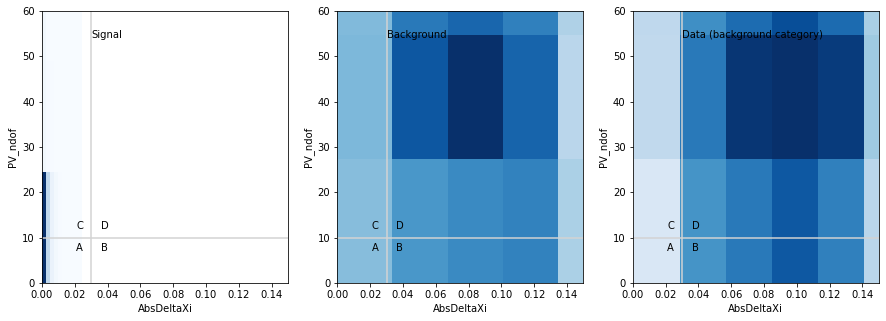

In [8]:
import matplotlib.pyplot as plt

v1='AbsDeltaXi'
cut_v1=0.03
range_v1=(0,0.15)

v2='PV_ndof'
cut_v2=10
range_v2=(0,60)

#v2='Acopl'
#cut_v2=0.03
#range_v2=(0,1)

def doScatter(df,label, ax):
    ax.hist2d(df[v1],df[v2],cmap='Blues')
    ax.set_xlim(*range_v1)
    ax.set_ylim(*range_v2)
    ax.set_xlabel(v1)
    ax.set_ylabel(v2)
    ax.plot([cut_v1,cut_v1],[range_v2[0],range_v2[1]],color='lightgray')
    ax.plot([range_v1[0],range_v1[1]],[cut_v2,cut_v2],color='lightgray')
    ax.text(0.2,0.9,label, transform=ax.transAxes)
    ax.text(cut_v1*0.7,cut_v2*0.7,'A')
    ax.text(cut_v1*1.2,cut_v2*0.7,'B')
    ax.text(cut_v1*0.7,cut_v2*1.2,'C')
    ax.text(cut_v1*1.2,cut_v2*1.2,'D')
    

    
fig, ax = plt.subplots(1, 3, figsize=(15,5))
doScatter(df_signal_prep,'Signal',ax[0])
doScatter(df_bkg_prep,'Background',ax[1])
doScatter(df_data_prep[df_data_prep['clf_categ']==0],'Data (background category)',ax[2])

plt.show()

We now apply the ABCD method with a simple function... and the background is estimated!

**TASK 2**

Discusion: Is this method perfect? 
How is the closure affected if the cuts are different?
Is there any extra dependency (e.g. on data-taking era, pileup, dilepton variables, etc.)?
What are the final uncertainties we can associate to this method?

In [9]:
def getABCDYields(df):
    
    """gets the yields in the different abcd regions"""

    mask_a=(df[v1]<cut_v1) &(df[v2]<cut_v2)
    mask_b=(df[v1]>cut_v1) &(df[v2]<cut_v2)
    mask_c=(df[v1]<cut_v1) &(df[v2]>cut_v2)
    mask_d=(df[v1]>cut_v1) &(df[v2]>cut_v2)
    
    yields={'A':df[mask_a].shape[0],
            'B':df[mask_b].shape[0],
            'C':df[mask_c].shape[0],
            'D':df[mask_d].shape[0]}

    return yields
 
def getABCDPrediction(df):
    
    """
    starting from the yields in the different regions, applies the ABCD formula
    returns the number of events observed in the signal region and the estimated number of events
    """
    
    yields=getABCDYields(df)
    
    return yields['A'],yields['B']*yields['C']/yields['D']


In [10]:
print('\nData (background category)')
nA,nAest=getABCDPrediction(df_data_prep[df_data_prep['clf_categ']==0])
print('nA(obs)=%d nA(est)=%3.1f bias=%3.3f'%(nA,nAest,nAest/nA))

print('\nData (background)')
nA,nAest=getABCDPrediction(df_bkg_prep)
print('nA(obs)=%d nA(est)=%3.1f bias=%3.3f'%(nA,nAest,nAest/nA))

#compute systematic error from closure test on background
SYS_ERROR = '%2.2f'%(nAest/nA if (nAest > nA) else nA/nAest)
print('syst_bkg = '+SYS_ERROR)


Data (background category)
nA(obs)=7 nA(est)=11.0 bias=1.566

Data (background)
nA(obs)=24 nA(est)=29.6 bias=1.232
syst_bkg = 1.23


## Gearing up for the statistical analysis

In the following we'll prepare a so called datacard reporting the yields in each region for the signal and the background, as well as their associated uncertainties. This datacard will be used as input for the Higgs Combination tool. More details on this tool can be found in [here](https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit).

We start by preparing a ROOT file which will contain the counting histograms.
For the moment this will be simple 1bin histograms with event counts but after you understand the example you can evolve this to be based on the distribution of a variable.

In [11]:
import ROOT

samples={'bkg':df_bkg_prep,
         'sig':df_signal_prep,
         'data_obs':df_data_prep}

#loop over the samples
#get yields in the different regions
yields_abcd={}
for df_name,df in samples.items():    
    yields_abcd[df_name]=getABCDYields(df)
    
#apply a scale factor to the background estimation such that it matches the data in region D
bkgSF=yields_abcd['data_obs']['D']/yields_abcd['bkg']['D']
for x in yields_abcd['bkg']: 
    yields_abcd['bkg'][x]=bkgSF*yields_abcd['bkg'][x]
print('Background estimation has been scaled by %3.3f'%bkgSF)

#apply a scale factor to the signal to normalize by luminosity
sigSF=lumi*sig_acc*sig_xsec

#normalize the signal to the total number of events
sigSF=sigSF/df_counts_signal['All']

for x in yields_abcd['sig']: 
    yields_abcd['sig'][x]=sigSF*yields_abcd['sig'][x]
print('Signal estimation has been scaled by %3.3f'%sigSF)

#template for the shape of the distribution to analyze
shapeH=ROOT.TH1F('shape','shape',1,0,1)
shapeH.SetDirectory(0)

#open the output file
fOut=ROOT.TFile.Open('shapes'+eras[0]+'_'+stream+'.root','RECREATE')

#loop over the samples
for df_name in samples:    
    
    #save the counts in histogram and store them in the file
    for region in yields_abcd[df_name]:
        shape=shapeH.Clone('{}_{}'.format(df_name,region))
        shape.SetBinContent(1,yields_abcd[df_name][region])
        shape.SetDirectory(fOut)
        shape.Write()

print('Writes: '+fOut.GetName())
fOut.Close()

shapeH.Delete()

Welcome to JupyROOT 6.24/06
Background estimation has been scaled by 0.746
Signal estimation has been scaled by 0.000
Writes: shapesB_Mu.root


In [12]:
#open a txt file to hold the datacard
dc=open('datacard'+eras[0]+'_'+stream+'.dat','w')

dc.write('imax *  number of channels\n')
dc.write('jmax *  number of processes -1\n')
dc.write('kmax *  number of nuisance parameters (sources of systematical uncertainties)\n')
dc.write('-------\n')

#spell out out the shapes are stored in the ROOT file
dc.write('shapes * * shapes'+eras[0]+'_'+stream+'.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC\n')

#add the data observations
dc.write('bin          A   B   C   D\n')
dc.write('observation  {0} {1} {2} {3}\n'.format(yields_abcd['data_obs']['A'],
                                                 yields_abcd['data_obs']['B'],
                                                 yields_abcd['data_obs']['C'],
                                                 yields_abcd['data_obs']['D']))
dc.write('-------\n')

#add the expectations for signal and background
dc.write('bin         A    A    B   B   C   C   D   D\n')
dc.write('process     sig  bkg  sig bkg sig bkg sig bkg\n')
dc.write('process     0    1    0   1   0   1   0   1\n')
dc.write('rate        {0:.3f}  {1:.3f}  {2:.3f} {3:.3f} {4:.3f} {5:.3f} {6:.3f} {7:.3f}\n'.format(yields_abcd['sig']['A'],
                                                                                                  yields_abcd['bkg']['A'],
                                                                                                  yields_abcd['sig']['B'],
                                                                                                  yields_abcd['bkg']['B'],
                                                                                                  yields_abcd['sig']['C'],
                                                                                                  yields_abcd['bkg']['C'],
                                                                                                  yields_abcd['sig']['D'],
                                                                                                  yields_abcd['bkg']['D'],
                                                                                                 ))
dc.write('-------\n')

#add 2.7% unc. on luminosity
dc.write('lumi lnN 1.027 - 1.027 - 1.027 - 1.027 -\n')
if '1.00' not in SYS_ERROR: 
    dc.write('syst_bkg lnN - '+SYS_ERROR+' - - - - - -\n')

#spell-out the ABCD method
dc.write('alpha rateParam A bkg (@0*@1/@2) beta,gamma,delta\n')
dc.write('beta  rateParam B bkg {}\n'.format(yields_abcd['bkg']['B']))
dc.write('gamma rateParam C bkg {}\n'.format(yields_abcd['bkg']['C']))
dc.write('delta rateParam D bkg {}\n'.format(yields_abcd['bkg']['D']))
         
#all done
dc.close()

print('datacard'+eras[0]+'_'+stream+'.dat is ready to be used with combine\n\n')
import os
_=os.system('cat datacard'+eras[0]+'_'+stream+'.dat')

datacardB_Mu.dat is ready to be used with combine


imax *  number of channels
jmax *  number of processes -1
kmax *  number of nuisance parameters (sources of systematical uncertainties)
-------
shapes * * shapesB_Mu.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
bin          A   B   C   D
observation  22 149 260 2010
-------
bin         A    A    B   B   C   C   D   D
process     sig  bkg  sig bkg sig bkg sig bkg
process     0    1    0   1   0   1   0   1
rate        0.826  17.913  0.000 161.964 0.166 273.921 0.000 2010.000
-------
lumi lnN 1.027 - 1.027 - 1.027 - 1.027 -
syst_bkg lnN - 1.23 - - - - - -
alpha rateParam A bkg (@0*@1/@2) beta,gamma,delta
beta  rateParam B bkg 161.96435202376531
gamma rateParam C bkg 273.9212773858151
delta rateParam D bkg 2010.0


## Running the Higgs Combination tool for the statistical analysis

The short exercise on statistical analysis should be used as a reference - [link](https://cmsdas.github.io/statistics-short-exercise/).
as well as the documentation of combine ([here](https://cms-analysis.github.io/HiggsAnalysis-CombinedLimit)). 
Some basic commands are listed below just to get started:
    
* Create the workspace: `text2workspace.py datacard.dat -o workspace.root`
* Running fit diagnostics: `combine -M FitDiagnostics workspace.root -t -1 --expectSignal=1`
* Compute the expected significance (asymptotic): `combine workspace.root -M Significance -t -1 --expectSignal=1`
* Likelihood scan: `combine workspace.root -M MultiDimFit --algo grid --points 100 --fastScan --expectSignal=1 -t -1`
* Compute the goodness-of-fit: `combine -M GoodnessOfFit workspace.root --algo=saturated --expectSignal=1 -t -1`